#Steps to Run
1. install torchdiffeq and import libraries as mentioned in notebook.

2. Upload the dataset training_data.csv and testing_data.csv as provided in assignment

3. Just run below cells sequentially anywhere in local or google coalab or kaggle.
4. Training for 130 epoch was optimal and took only 30-40 min( minimum training of 70-80 epochs is required for significant results just takes 15 minutes of time).
OR
5. You can download my saved model from [link to saved model](https://drive.google.com/file/d/1CrdtRp7noOsMex8BRB6DCeImZI35GUVG/view?usp=sharing) and load it using:
model = MethanODE(state_dim=54, hidden_size=256).to(device)
model.load_state_dict(torch.load("/content/methanode_ABHI_trained.pth", map_location=device))

6. For any other query, can ask me on watsapp-9696333760 or email-bt22csd040@iiitn.ac.in
7. CUDA or cpu both can be used.

In [ ]:
!pip install torchdiffeq

# MethanODE (my custom name): A Neural ODE Framework for Methane Combustion Modeling
 Inspired by the ChemNODE (2022) Paper
This notebook presents MethanODE, a Neural Ordinary Differential Equation (Neural ODE) based model developed to simulate the chemical kinetics of methane combustion using the GRI-Mech 3.0 mechanism. The approach draws core inspiration from the ChemNODE (2022) paper, which applied neural ODEs to hydrogen combustion.

We extend the idea to a more complex system involving 53 chemical species and temperature, aiming to accurately learn and predict their temporal evolution from provided training data. The model is trained species-wise, with a hybrid system combining ground truth and predictions for stable learning.

* This work was completed as part of a Siemens-sponsored assignment at IIITN.
* Dataset: Provided time-series for training and testing chemical states.
* Objective: Predict the full trajectory of the system on unseen test data using a scientifically grounded and data-driven approach.

In [ ]:
# =====================================
# STEP 1: Importing Libraries
# =====================================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint #The core method to solve Neural ODEs.
from sklearn.preprocessing import StandardScaler #To normalize the data for better training convergence.
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.interpolate import interp1d #Used to interpolate time series data to a consistent time grid
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# ===========================================
# STEP 2: Load and Preprocess Data
# ===========================================
# Loading datasets
train_df = pd.read_csv("/content/training_data.csv")
test_df = pd.read_csv("/content/testing_data.csv")

# Defining species columns (y1 to y53 + temperature)
species_cols = [f"y{i}" for i in range(1, 54)]

species_scaler = StandardScaler()
temp_scaler = StandardScaler()

# Scaling training data
train_species = species_scaler.fit_transform(train_df[species_cols])
train_temp = temp_scaler.fit_transform(train_df[["temperature"]])
train_y = np.hstack([train_species, train_temp]).astype(np.float32)

# Scaling test data (using training scalers)
test_species = species_scaler.transform(test_df[species_cols])
test_temp = temp_scaler.transform(test_df[["temperature"]])
test_y = np.hstack([test_species, test_temp]).astype(np.float32)

# Getting dimensions
state_dim = train_y.shape[1]  # 53 species + temperature = 54
time_points = len(train_df['time'])

 # Model Structure:
Input: Species concentrations + Temperature + Time

Encoder: Shared 2-layer MLP with SiLU activation

Species Heads: Lightweight 2-layer MLP for each species

Residual Connection: Adds 0.1 * y (ResNet-style)

# Physics Constraints:
Mass Conservation: Penalizes negative total mass

Temperature Control: Prevents cooling below 300K

# Output:
Returns dydt (rate of change) for each species and temperature.

In [ ]:
# =============================================
# STEP 3: Defining the Neural ODE Model(methanode[my custom name])
# =============================================
class MethanODE(nn.Module):
    def __init__(self, state_dim, hidden_size=256):
        super().__init__()
        self.state_dim = state_dim

        # Shared encoder for all species
        self.shared_encoder = nn.Sequential(
            nn.Linear(state_dim + 1, hidden_size),  # +1 for time dimension
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU()
        )

        # Lightweight heads for each species
        self.species_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, 64),
                nn.SiLU(),
                nn.Linear(64, 1))
            for _ in range(state_dim)])

        # Physics constraints
        self.mass_weights = nn.Parameter(torch.ones(state_dim), requires_grad=False)
        self.temp_idx = state_dim - 1  # Temperature is last column

    def forward(self, t, y):
        # Handle single sample case
        if y.dim() == 1:
            y = y.unsqueeze(0)

        # Adding time as an input feature
        time_tensor = torch.ones(y.size(0), 1, device=y.device) * t
        x = torch.cat([y, time_tensor], dim=1)

        # Shared feature extraction
        features = self.shared_encoder(x)

        # Species-specific predictions with residual connection[LIKE RESNET]
        dydt = torch.cat([head(features) + 0.1*y[:, i:i+1]
                         for i, head in enumerate(self.species_heads)], dim=1)

        # Physics-based corrections
        mass = (y * self.mass_weights).sum(dim=1, keepdim=True)
        dydt = dydt - 0.1 * F.relu(-mass) * y  # Mass conservation

        # Temperature-specific constraints
        if self.temp_idx is not None:
            temp = y[:, self.temp_idx]
            dydt[:, self.temp_idx] -= 0.1 * F.relu(-dydt[:, self.temp_idx]) * (temp < 300)

        return dydt.squeeze()


TRAINING FUNCTION :

In [ ]:
def train_model(model, train_time, train_y, epochs=130, lr=0.01):
    model.to(device)

    # Convert data to tensors
    t_tensor = torch.tensor(train_time, dtype=torch.float32, device=device)
    y_true = torch.tensor(train_y, dtype=torch.float32, device=device)
    y0 = y_true[0].clone()

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.005)
    # Pre-calculating adaptive weights
    with torch.no_grad():
        spike_threshold = y_true.mean(dim=0) + 3 * y_true.std(dim=0)
        is_spike = (y_true > spike_threshold).float()
        weights = 1.0 + 9.0 * is_spike
        weights /= weights.mean(dim=0)

    loss_curve = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = odeint(model, y0, t_tensor, method='dopri5')
        errors = y_pred - y_true

        weighted_mse = (weights * errors ** 2).mean()
        grad_loss = 0.2 * F.mse_loss(torch.diff(y_pred, dim=0), torch.diff(y_true, dim=0))
        base_mse = 0.3 * F.mse_loss(y_pred, y_true)

        loss = weighted_mse + grad_loss + base_mse

        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()

        loss_curve.append(loss.item())

        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                spike_mae = (is_spike * torch.abs(errors)).sum() / (is_spike.sum() + 1e-6)
                flat_mae = ((1 - is_spike) * torch.abs(errors)).sum() / ((1 - is_spike).sum() + 1e-6)

            print(f"Epoch {epoch + 1}/{epochs} | Loss: {loss.item():.4e} | "
                  f"Spike MAE: {spike_mae.item():.4e} | Flat MAE: {flat_mae.item():.4e}")

    return model, loss_curve


In [ ]:
# =============================================
# STEP 4: Model Training
# =============================================
model = MethanODE(state_dim, hidden_size=256).to(device)
print(f"Model contains {sum(p.numel() for p in model.parameters()):,} parameters")

print("\nStarting training...")
model, loss_curve = train_model(model, train_df['time'].values, train_y, epochs=130)

Model contains 971,884 parameters

Starting training...
Epoch 10/130 | Loss: 6.0669e+00 | Spike MAE: 5.4379e+00 | Flat MAE: 4.9984e-01
Epoch 20/130 | Loss: 5.2493e+00 | Spike MAE: 4.6301e+00 | Flat MAE: 9.0344e-01
Epoch 30/130 | Loss: 5.2122e+00 | Spike MAE: 4.4982e+00 | Flat MAE: 9.3088e-01
Epoch 40/130 | Loss: 5.1609e+00 | Spike MAE: 4.5366e+00 | Flat MAE: 8.8652e-01
Epoch 50/130 | Loss: 5.0281e+00 | Spike MAE: 4.4479e+00 | Flat MAE: 8.9282e-01
Epoch 60/130 | Loss: 4.4724e+00 | Spike MAE: 3.9409e+00 | Flat MAE: 9.2061e-01
Epoch 70/130 | Loss: 2.9492e+00 | Spike MAE: 2.3389e+00 | Flat MAE: 7.2907e-01
Epoch 80/130 | Loss: 2.2401e+00 | Spike MAE: 2.1383e+00 | Flat MAE: 4.6498e-01
Epoch 90/130 | Loss: 1.7736e+00 | Spike MAE: 1.3498e+00 | Flat MAE: 4.5012e-01
Epoch 100/130 | Loss: 1.5354e+00 | Spike MAE: 1.3761e+00 | Flat MAE: 3.5570e-01
Epoch 110/130 | Loss: 1.5407e+00 | Spike MAE: 1.4374e+00 | Flat MAE: 3.3137e-01
Epoch 120/130 | Loss: 1.2909e+00 | Spike MAE: 1.2073e+00 | Flat MAE: 3.16

In [ ]:
# Save the model
torch.save(model.state_dict(), "/content/methanode_ABHI_trained.pth")
print("Model saved as methanode_trained.pth")


Model saved as methanode_trained.pth


PLOT 1: TRAINING CURVE

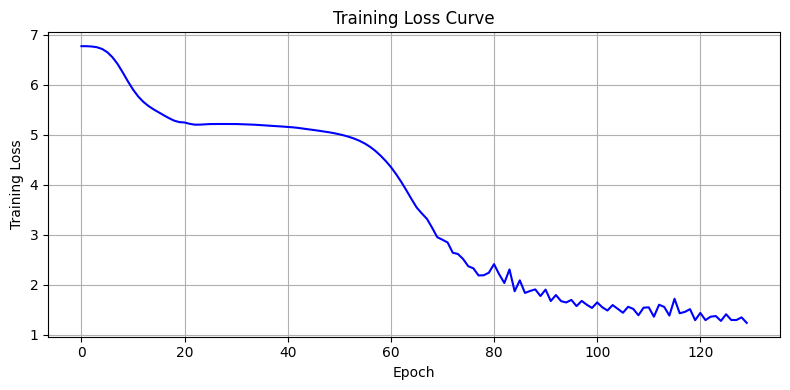

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(loss_curve, color='blue')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# =============================================
# STEP 5: Prediction and Evaluation
# =============================================
def evaluate_model(model, test_time, test_y):
    # Convert to tensors
    t_tensor = torch.tensor(test_time, dtype=torch.float32, device=device)
    y0 = torch.tensor(test_y[0], dtype=torch.float32, device=device)

    # Make predictions
    with torch.no_grad():
        test_pred = odeint(model, y0, t_tensor).cpu().numpy()

    # Inverse scaling
    test_pred_species = species_scaler.inverse_transform(test_pred[:, :-1])
    test_pred_temp = temp_scaler.inverse_transform(test_pred[:, -1:])
    test_actual_species = species_scaler.inverse_transform(test_y[:, :-1])
    test_actual_temp = temp_scaler.inverse_transform(test_y[:, -1:])

    return test_pred_species, test_pred_temp, test_actual_species, test_actual_temp

# Run evaluation
print("\nEvaluating model...")
pred_species, pred_temp, actual_species, actual_temp = evaluate_model(
    model, test_df['time'].values, test_y)



Evaluating model...


In [ ]:
print(type(actual_species), type(pred_species))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
# --- Temperature Metrics ---
mae_temp = mean_absolute_error(actual_temp, pred_temp)
rmse_temp = np.sqrt(mean_squared_error(actual_temp, pred_temp))
print(f"\nTemperature MAE:  {mae_temp:.4f}")
print(f"Temperature RMSE: {rmse_temp:.4f}")
print("actual_species shape:", actual_species.shape)
print("pred_species shape:", pred_species.shape)

# --- Species Metrics (average over all 53 species) ---
mae_species = mean_absolute_error(actual_species, pred_species)
rmse_species = np.sqrt(mean_squared_error(actual_species, pred_species))
print(f"\nSpecies (average) MAE:  {mae_species:.2e}")
print(f"Species (average) RMSE: {rmse_species:.2e}")



Temperature MAE:  34.8515
Temperature RMSE: 49.4598
actual_species shape: (501, 53)
pred_species shape: (501, 53)

Species (average) MAE:  2.37e-04
Species (average) RMSE: 1.13e-03


PLOT 2: ACTUAL VS PREDICTED TEMPERATURE WITH TIME

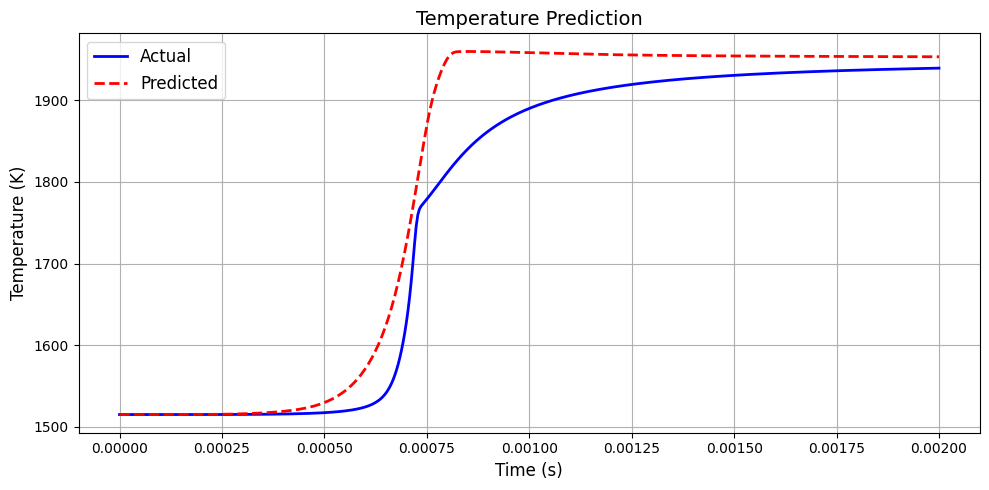

In [ ]:
def plot_results(time, actual, pred, title, ylabel):
    plt.figure(figsize=(10, 5))
    plt.plot(time, actual, 'b-', label='Actual', linewidth=2)
    plt.plot(time, pred, 'r--', label='Predicted', linewidth=2)
    plt.title(title, fontsize=14)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot temperature
plot_results(test_df['time'], actual_temp.flatten(), pred_temp.flatten(),
            'Temperature Prediction', 'Temperature (K)')


PLOT 3: ACTUAL VS PREDICTED CONCENTRATION OF SOME SPECIES WITH TIME

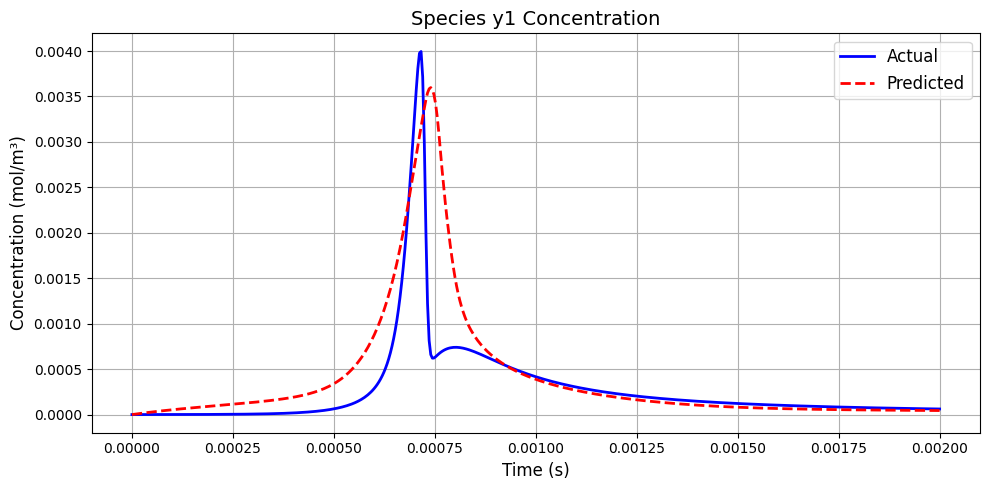

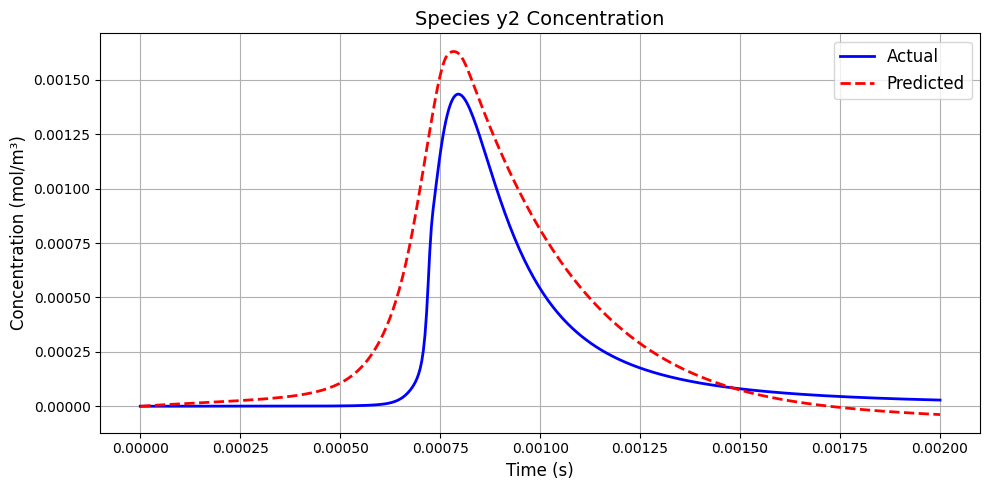

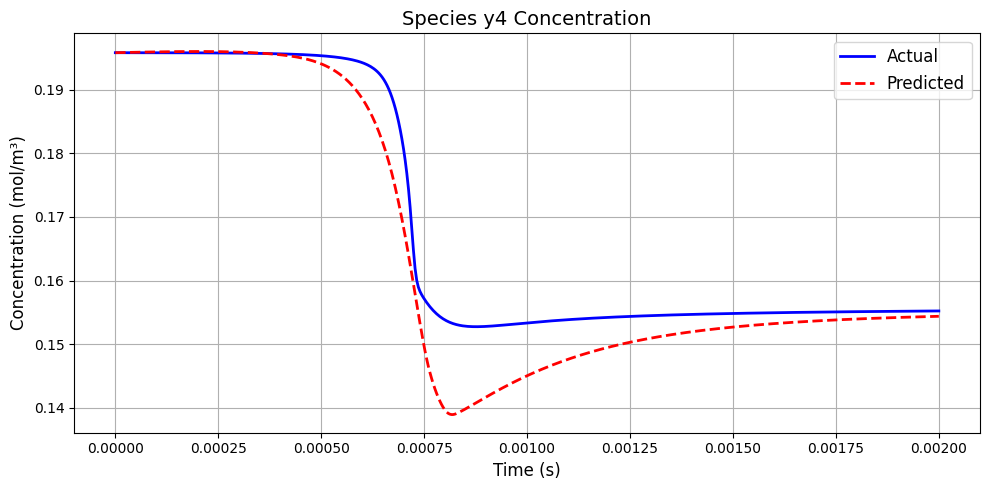

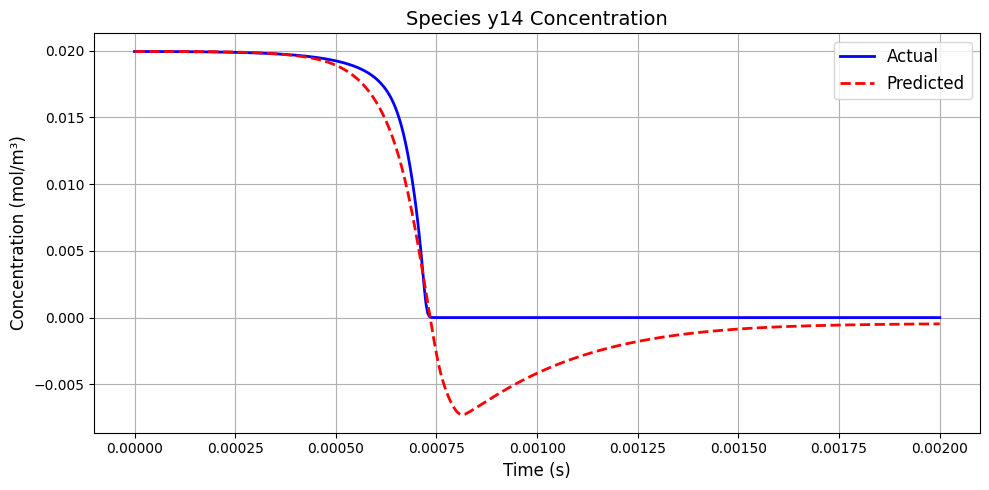

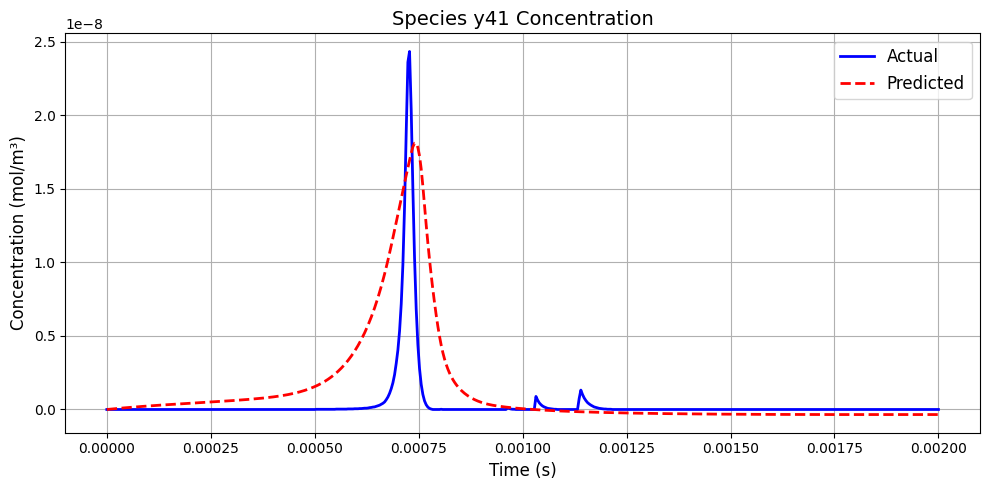

In [ ]:
important_indices = [0, 1, 3, 13, 40]# random
# Plot important species
for idx in important_indices:
    plot_results(test_df['time'],
                actual_species[:, idx], pred_species[:, idx],
                f'Species y{idx+1} Concentration',
                'Concentration (mol/m³)')

PLOT 3: MAE & RMSE VALUES OF TEMPERATURE

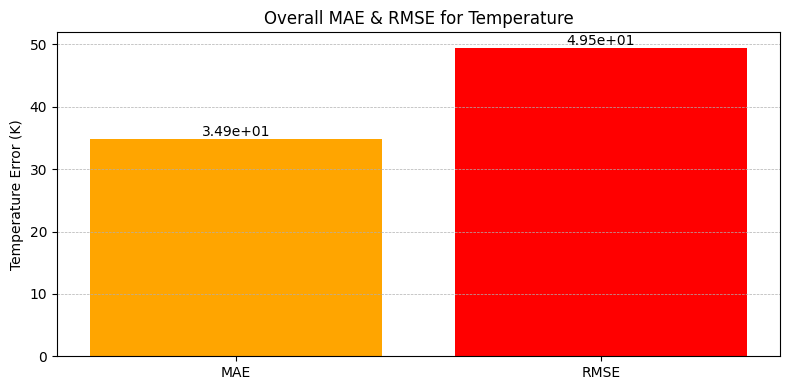

In [ ]:
metrics = ['MAE', 'RMSE']
values = [mae_temp, rmse_temp]

# Plot
plt.figure(figsize=(8, 4))
bars = plt.bar(metrics, values, color=['orange', 'red'])

# Add values above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.001, f"{yval:.2e}", ha='center', va='bottom')

plt.ylabel('Temperature Error (K)')
plt.title('Overall MAE & RMSE for Temperature')
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



PLOT 5: Computing per-species MAE and RMSE VALUES

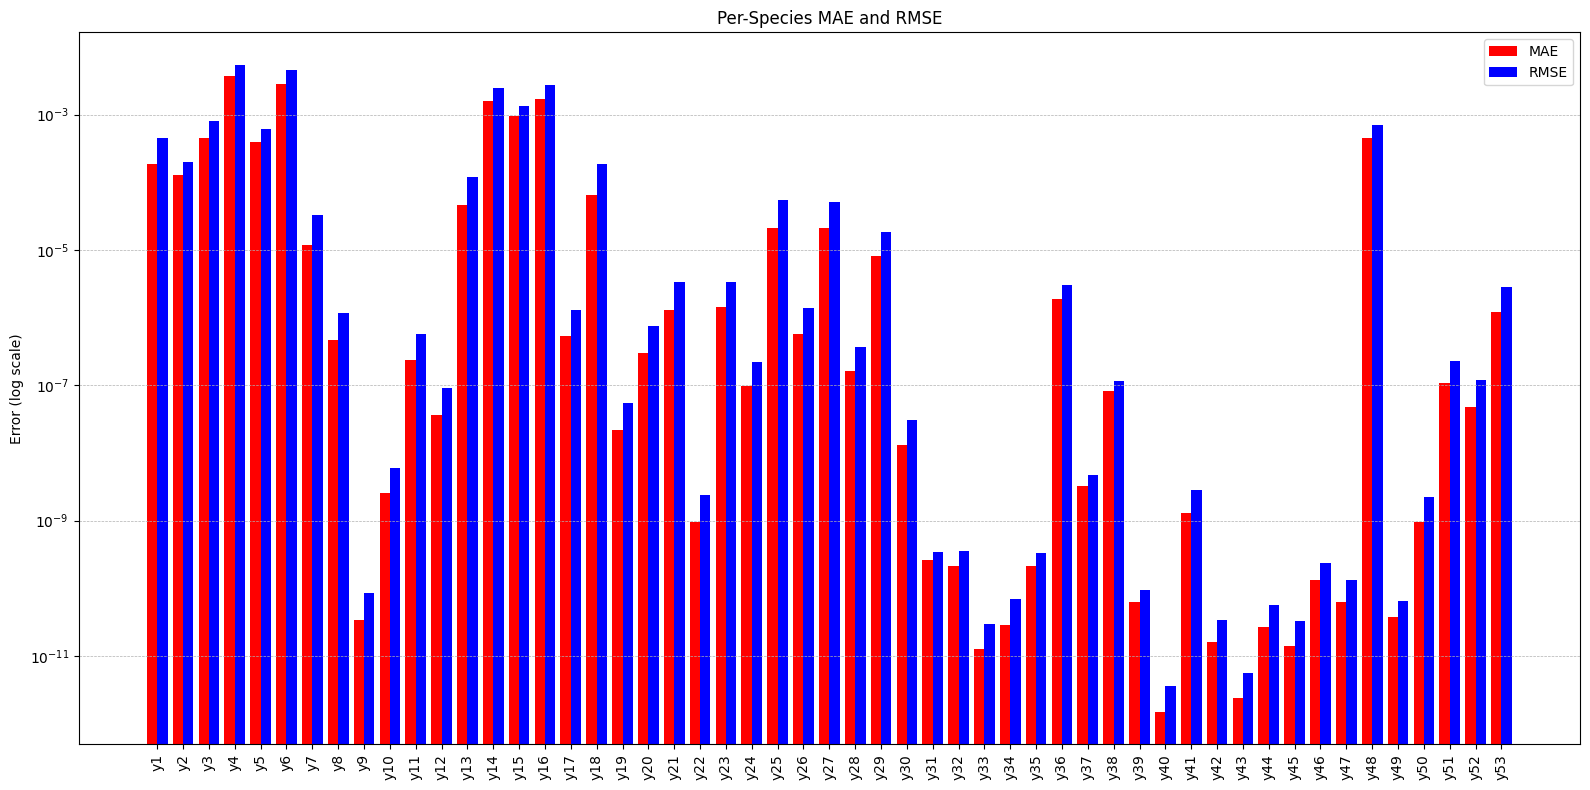

In [ ]:

mae_list = []
rmse_list = []
num_species = actual_species.shape[1]

for i in range(num_species):
    mae = mean_absolute_error(actual_species[:, i], pred_species[:, i])
    rmse = np.sqrt(mean_squared_error(actual_species[:, i], pred_species[:, i]))
    mae_list.append(mae)
    rmse_list.append(rmse)

species_labels = [f"y{i+1}" for i in range(num_species)]

# X positions for species
x = np.arange(num_species)
width = 0.4  # width of each bar

# Plot
plt.figure(figsize=(16, 8))
plt.bar(x - width/2, mae_list, width=width, label='MAE', color='red')
plt.bar(x + width/2, rmse_list, width=width, label='RMSE', color='blue')

# Formatting
plt.xticks(x, species_labels, rotation=90)
plt.yscale('log')  # Using log scale
plt.ylabel('Error (log scale)')
plt.title('Per-Species MAE and RMSE')
plt.legend()
plt.grid(True, which="both", axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


PLOT 6: Each neuaral network for each speicies predicts it's rate of change with time. Its Overall concentration is calculated by :

[Original conc + dy/dt * time]

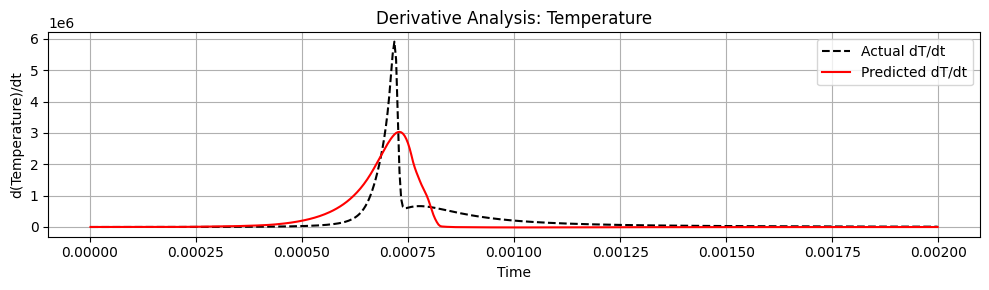

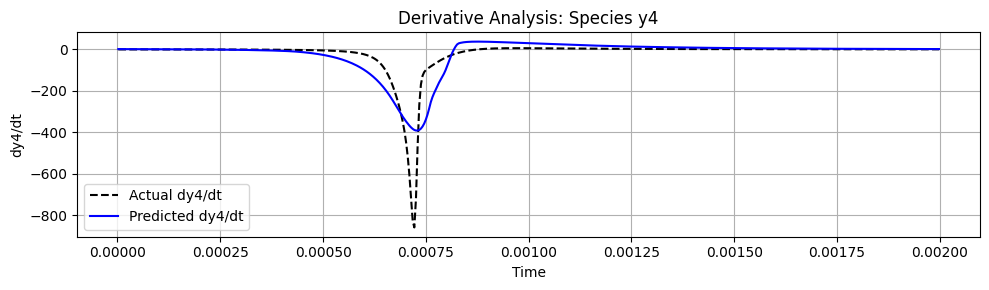

In [ ]:
time = test_df['time'].values
# Computing numerical derivative using finite differences
dt = np.diff(time)

# Temperature derivatives (predicted & actual)
dT_pred = np.diff(pred_temp.squeeze()) / dt
dT_actual = np.diff(actual_temp.squeeze()) / dt

# Species y4 derivatives (index=3)
dy4_pred = np.diff(pred_species[:, 3]) / dt
dy4_actual = np.diff(actual_species[:, 3]) / dt

# Midpoints for time axis (since diff reduces length by 1)
time_mid = 0.5 * (time[1:] + time[:-1])

# --- Plot: Temperature Derivative ---
plt.figure(figsize=(10, 3))
plt.plot(time_mid, dT_actual, label='Actual dT/dt', linestyle='--', color='black')
plt.plot(time_mid, dT_pred, label='Predicted dT/dt', color='red')
plt.title('Derivative Analysis: Temperature')
plt.xlabel('Time')
plt.ylabel('d(Temperature)/dt')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot: Species y4(Random) Derivative ---
plt.figure(figsize=(10, 3))
plt.plot(time_mid, dy4_actual, label='Actual dy4/dt', linestyle='--', color='black')
plt.plot(time_mid, dy4_pred, label='Predicted dy4/dt', color='blue')
plt.title('Derivative Analysis: Species y4')
plt.xlabel('Time')
plt.ylabel('dy4/dt')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


PLOT 7 :  Correlation Plot: Actual vs Predicted Species

This plot shows the **Pearson correlation coefficient (R)** between the actual and predicted concentration profiles for each species.


High correlation indicates that the model successfully learns the **shape and dynamics** of the species over time, not just the average values.

> Note: Even a low-concentration species can have high correlation if the model learns its pattern correctly.


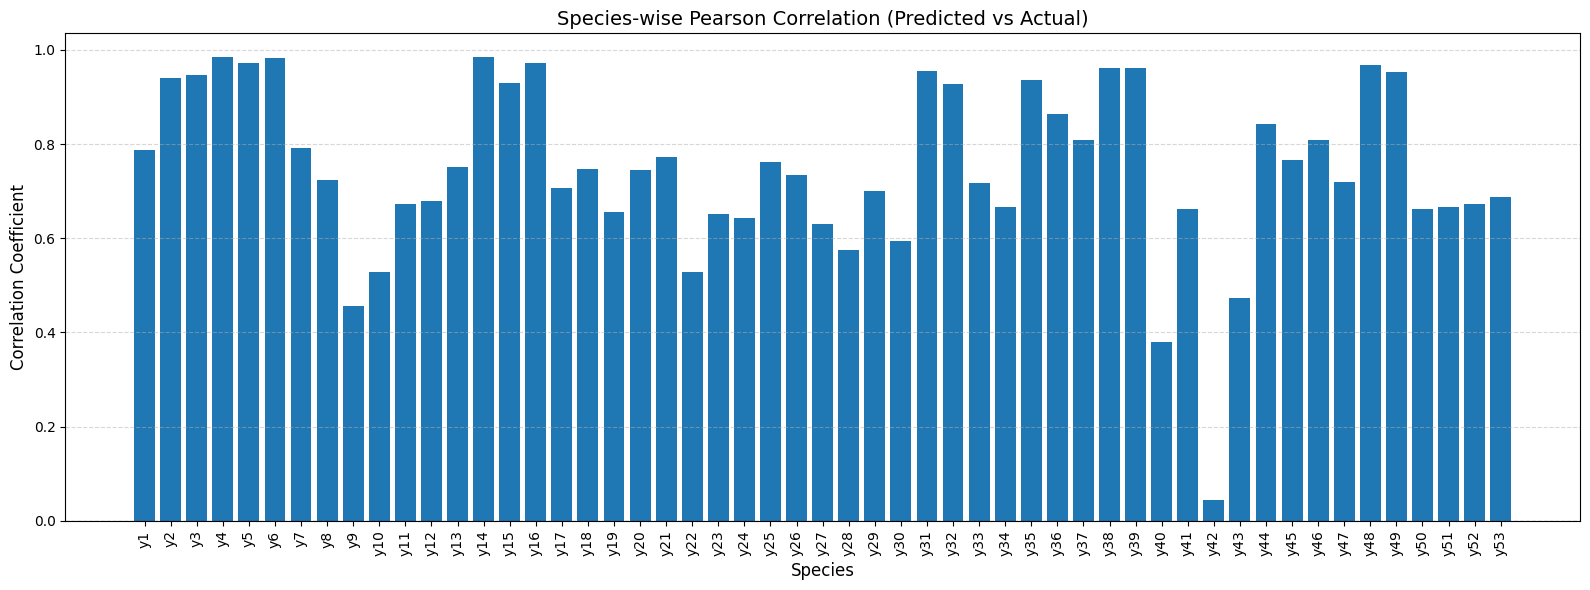

In [ ]:
# Calculating Pearson correlation for each species
correlations = [
    np.corrcoef(actual_species[:, i], pred_species[:, i])[0, 1]
    for i in range(actual_species.shape[1])
]

plt.figure(figsize=(16, 6))
x = np.arange(len(correlations))
plt.bar(x, correlations, color="#1f77b4")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')

plt.title("Species-wise Pearson Correlation", fontsize=14)
plt.xlabel("Species", fontsize=12)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.xticks(x, [f"y{i+1}" for i in range(len(correlations))], rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


PLOT 8: SHOWING RMSE VALUES OF ALL SPECIES THROUGH A LINE CHART

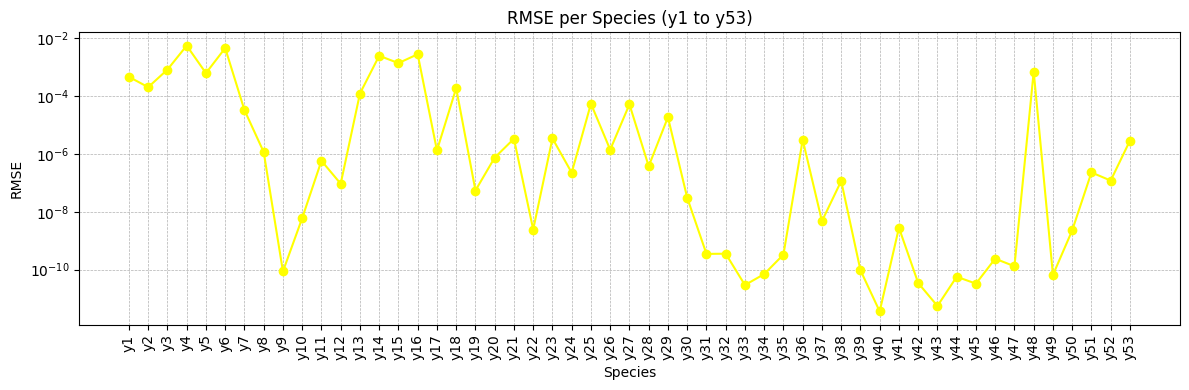

In [ ]:
num_species = actual_species.shape[1]
rmse_per_species = [
    np.sqrt(mean_squared_error(actual_species[:, i], pred_species[:, i]))
    for i in range(num_species)
]

# X-axis: species indices (1 to 53)
species_indices = np.arange(1, num_species + 1)

# Plot as line chart
plt.figure(figsize=(12, 4))
plt.plot(species_indices, rmse_per_species, marker='o', linestyle='-', color='yellow')

# Add labels and formatting
plt.xticks(species_indices, [f'y{i}' for i in species_indices], rotation=90)
plt.yscale('log')  # Optional: log scale to show small/large RMSE clearly
plt.xlabel("Species")
plt.ylabel("RMSE")
plt.title("RMSE per Species (y1 to y53)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


- - - - - Assignment submitted by Abhiudai-BT22CSD040 on 29/06/2025
